In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

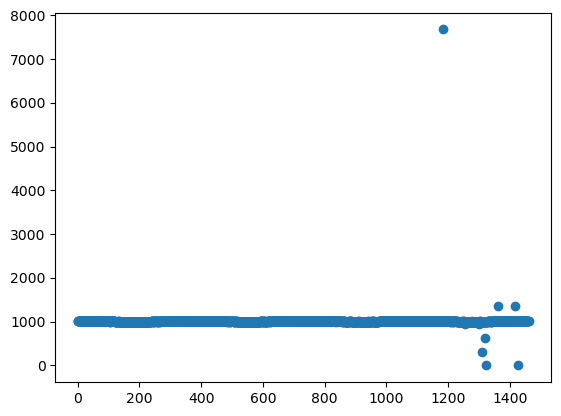

In [9]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [10]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


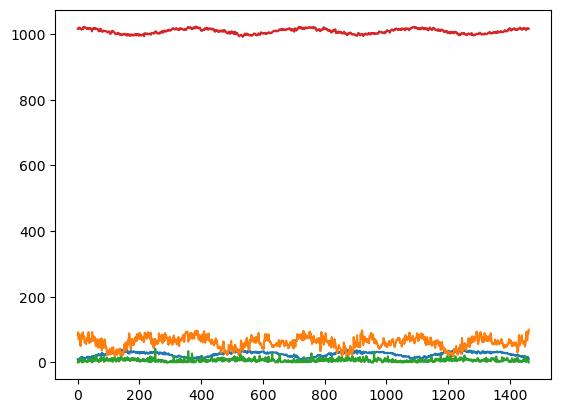

In [11]:
plt.plot(train)

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [13]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

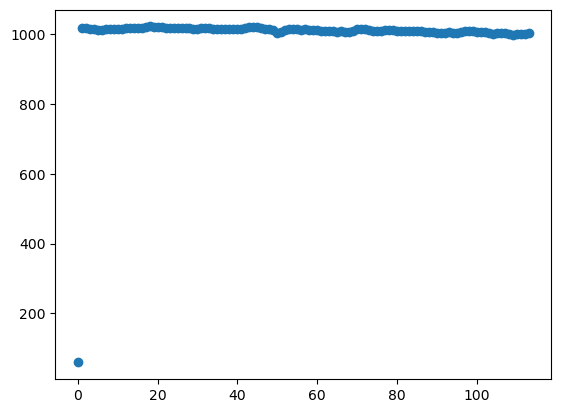

In [14]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [15]:
test.iloc[0][3] = test.iloc[1][3]

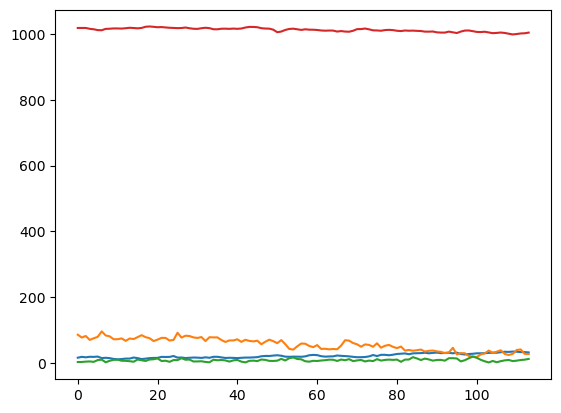

In [16]:
plt.plot(test)

## 1.2 Add Gauss Noise

In [17]:
import random

In [18]:
train_noised = train.copy()

In [19]:
for i in range(len(train_noised)):
    for j in range(4):
        train_noised.iloc[i][j] += random.gauss(0, 5)

In [20]:
train.iloc[0]

meantemp          10.000000
humidity          84.500000
wind_speed         0.000000
meanpressure    1015.666667
Name: 0, dtype: float64

In [21]:
train_noised.iloc[0]

meantemp           0.742536
humidity          90.876642
wind_speed         0.308913
meanpressure    1015.577089
Name: 0, dtype: float64

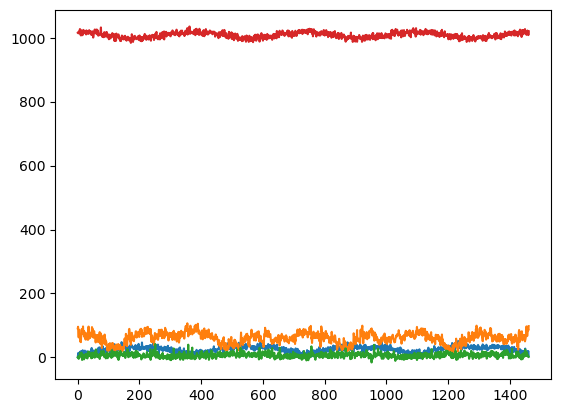

In [22]:
plt.plot(train_noised)

## 1.2 Transfer data to LSTM representation

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [25]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [26]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

train_processed_noised, train_scaler_noised = data_process(train_noised, window_size, predict_size)
X_train_noised, y_train_noised = train_processed_noised['datain'], train_processed_noised['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [27]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train_noised = torch.from_numpy(X_train_noised.astype(np.float32))
y_train_noised = torch.from_numpy(y_train_noised.astype(np.float32))

### - data loader

In [28]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
train_data_noised = Data.TensorDataset(X_train_noised, y_train_noised)
test_data = Data.TensorDataset(X_test, y_test)

In [29]:
print(f'size of train_data: {len(train_data)}')
print(f'size of train_data_noised: {len(train_data_noised)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of train_data_noised: 5832
size of test_data: 440


In [30]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [31]:
train_data_noised[0]

(tensor([-0.6480, -0.4353, -0.6490,  1.7468, -0.6281, -0.4237, -0.6443,  1.7492,
         -0.6164, -0.4586, -0.6426,  1.7531]),
 tensor([-0.6421, -0.5024, -0.6605,  1.7535]))

In [32]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [33]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [34]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [35]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [36]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [37]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [38]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [39]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [40]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        [ vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            [ vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        return vqc

## 2.3 Quantum-LSTM

In [41]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [42]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [43]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__(input_size, hidden_size, ctx = ctx)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

In [44]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
}

## 2.4 Stacked QLSTM

In [45]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical'):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [46]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

In [47]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical'):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [48]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {step + 1}/{epoch}: Loss: {train_loss / batch_size}')
        losses.append(train_loss / batch_size)
    
    return losses

## 3.2 Evaluate Model

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae])

## 3.3 Train Model

In [50]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [63]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

### - classical LSTM

In [55]:
model = Model(input_size, hidden_size, num_output, 
                num_layers = num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(model, train_data_noised, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 100)
end = time.time()

print(f'time costs: {end - start}')

Epoch 1/100: Loss: 1.0101100862026215
Epoch 2/100: Loss: 0.986893504858017
Epoch 3/100: Loss: 0.974490350484848
Epoch 4/100: Loss: 0.972030621767044
Epoch 5/100: Loss: 0.9808665126562118
Epoch 6/100: Loss: 0.9445485383272171
Epoch 7/100: Loss: 0.9433759331703186
Epoch 8/100: Loss: 0.9287796825170517
Epoch 9/100: Loss: 0.9202654331922531
Epoch 10/100: Loss: 0.9002810627222061
Epoch 11/100: Loss: 0.8553315311670303
Epoch 12/100: Loss: 0.8353217750787735
Epoch 13/100: Loss: 0.7878448098897934
Epoch 14/100: Loss: 0.7529410719871521
Epoch 15/100: Loss: 0.7107215851545334
Epoch 16/100: Loss: 0.6686615586280823
Epoch 17/100: Loss: 0.6027766436338424
Epoch 18/100: Loss: 0.5392724826931954
Epoch 19/100: Loss: 0.49244238138198854
Epoch 20/100: Loss: 0.42769960314035416
Epoch 21/100: Loss: 0.36462623029947283
Epoch 22/100: Loss: 0.30297438353300093
Epoch 23/100: Loss: 0.2691327199339867
Epoch 24/100: Loss: 0.2088881641626358
Epoch 25/100: Loss: 0.18569616451859475
Epoch 26/100: Loss: 0.1437884997

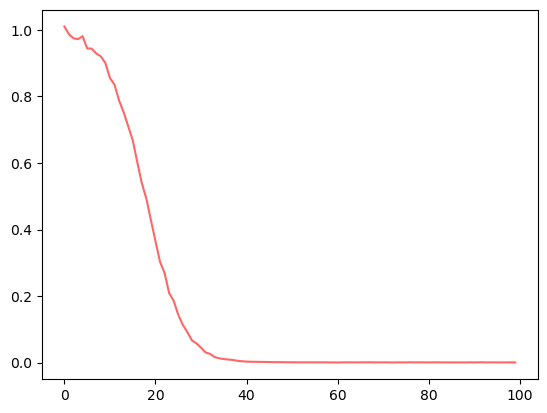

In [56]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [57]:
calculate_accuarcy(model, X_test, y_test)

array([ 98.43741879,  10.45015282, 109.20569396,   8.09953839])

In [58]:
# array([ 98.43741879,  10.45015282, 109.20569396,   8.09953839])

### - QLSTM

In [64]:
epoch = 5
acc, rmse, mse, mae = 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical')
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data_noised, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 50)
    end = time.time()

    print(f'time costs: {end - start}')
    
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)

epoch: 1
Epoch 1/50: Loss: 1.0390035599470138
Epoch 2/50: Loss: 1.023404797911644
Epoch 3/50: Loss: 0.9611702382564544
Epoch 4/50: Loss: 0.9224392861127854
Epoch 5/50: Loss: 0.8651433885097504
Epoch 6/50: Loss: 0.8121005892753601
Epoch 7/50: Loss: 0.7157762750983239
Epoch 8/50: Loss: 0.5647230118513107
Epoch 9/50: Loss: 0.44964745789766314
Epoch 10/50: Loss: 0.3718108020722866
Epoch 11/50: Loss: 0.4345301054418087
Epoch 12/50: Loss: 0.344758839905262
Epoch 13/50: Loss: 0.25972039327025415
Epoch 14/50: Loss: 0.23933690488338472
Epoch 15/50: Loss: 0.21987609192728996
Epoch 16/50: Loss: 0.14807305447757244
Epoch 17/50: Loss: 0.23252830244600772
Epoch 18/50: Loss: 0.18638447746634484
Epoch 19/50: Loss: 0.16999131813645363
Epoch 20/50: Loss: 0.12682981211692096
Epoch 21/50: Loss: 0.08518079118803143
Epoch 22/50: Loss: 0.07815415700897574
Epoch 23/50: Loss: 0.03646722100675106
Epoch 24/50: Loss: 0.03133660109597258
Epoch 25/50: Loss: 0.010874252335634082
Epoch 26/50: Loss: 0.0083120563314878

[98.51673285  9.13229798 83.39886636  7.68841913]
epoch: 5
Epoch 1/50: Loss: 0.9963252156972885
Epoch 2/50: Loss: 0.9830409318208695
Epoch 3/50: Loss: 1.015314069390297
Epoch 4/50: Loss: 0.9300335615873336
Epoch 5/50: Loss: 0.9874659448862075
Epoch 6/50: Loss: 0.8945453822612762
Epoch 7/50: Loss: 0.8393844813108444
Epoch 8/50: Loss: 0.7087256878614425
Epoch 9/50: Loss: 0.6980357006192207
Epoch 10/50: Loss: 0.6502280458807945
Epoch 11/50: Loss: 0.5148128233850002
Epoch 12/50: Loss: 0.5034282937645912
Epoch 13/50: Loss: 0.4087375447154045
Epoch 14/50: Loss: 0.3930268606171012
Epoch 15/50: Loss: 0.25862362440675496
Epoch 16/50: Loss: 0.33092322405427693
Epoch 17/50: Loss: 0.20890975948423146
Epoch 18/50: Loss: 0.21993917451472952
Epoch 19/50: Loss: 0.2171679176390171
Epoch 20/50: Loss: 0.11244452599203214
Epoch 21/50: Loss: 0.10563448081957176
Epoch 22/50: Loss: 0.11091457378352061
Epoch 23/50: Loss: 0.08469337858259678
Epoch 24/50: Loss: 0.053511257964419204
Epoch 25/50: Loss: 0.04721275

In [65]:
# mean acc:  98.39638569777435
# mean rmse:  11.060539460659989
# mean mse:  130.7398047513986
# mean mae:  8.312230783489008

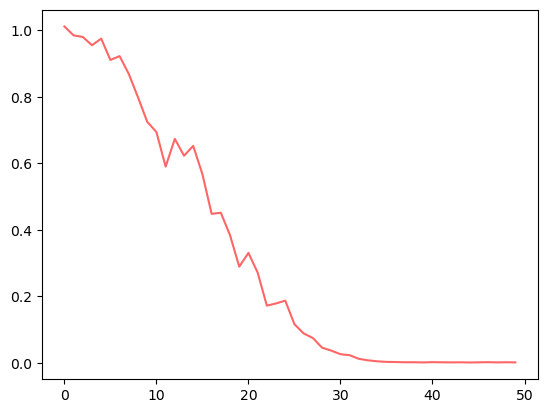

In [60]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [61]:
calculate_accuarcy(qmodel, X_test, y_test)

array([ 98.35952763,  11.61115746, 134.81897746,   8.50328217])

In [105]:
# array([ 98.52209099,  10.03566763, 100.71462476,   7.66064557])

In [84]:
with open('loss/noise/loss4.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [89]:
average_accuracy = np.mean([
    0.9808, 0.9839, 0.9791, 0.9832, 0.9712
])
average_accuracy

0.9796400000000001

In [85]:
average_time = np.mean([
    167.10324335098267, 169.0270173549652, 169.0270173549652, 169.0270173549652
])
average_time

168.54607385396957

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [447]:
# save the model
torch.save(qmodel.state_dict(), "model/qmodel_GRU.pt")

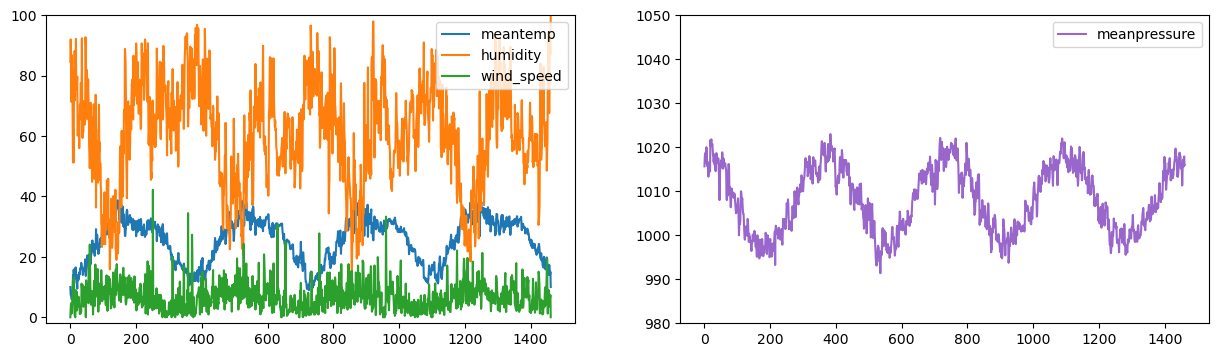

In [51]:
train1 = pd.DataFrame(train, columns=('meantemp',))
train2 = pd.DataFrame(train, columns=('humidity',))
train3 = pd.DataFrame(train, columns=('wind_speed',))
train4 = pd.DataFrame(train, columns=('meanpressure',))

plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(train1, label="meantemp")
plt.plot(train2, label="humidity")
plt.plot(train3, label="wind_speed")

plt.ylim(-2, 100)
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(train4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)

plt.legend()

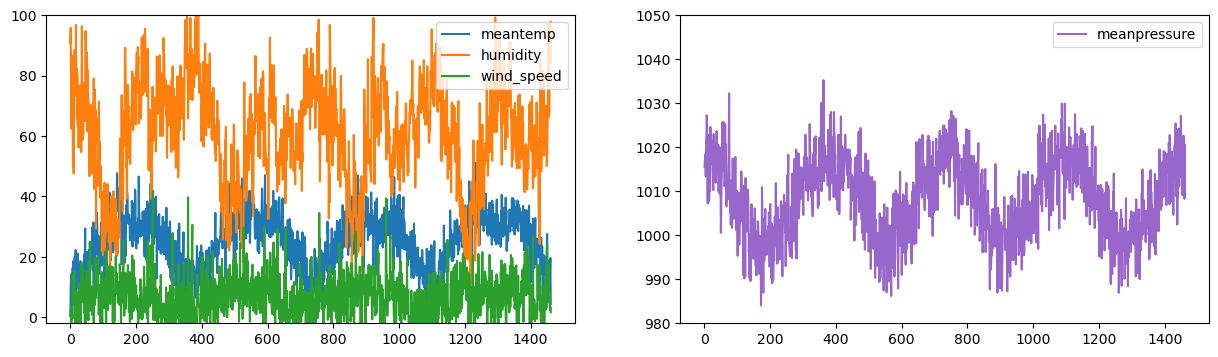

In [52]:
train_noised1 = pd.DataFrame(train_noised, columns=('meantemp',))
train_noised2 = pd.DataFrame(train_noised, columns=('humidity',))
train_noised3 = pd.DataFrame(train_noised, columns=('wind_speed',))
train_noised4 = pd.DataFrame(train_noised, columns=('meanpressure',))

plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(train_noised1, label="meantemp")
plt.plot(train_noised2, label="humidity")
plt.plot(train_noised3, label="wind_speed")

plt.ylim(-2, 100)
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(train_noised4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)

plt.legend()